# 🧠 Intel Image Classification - ResNet50 Optimized for CPU (Surya Dwi Satria)

In [29]:
# ========= IMPORT LIBRARY YANG DIBUTUHKAN =========
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, roc_auc_score
import time



In [ ]:
# ========= PARAMETER UTAMA =========
IMG_SIZE = 200         # ukuran gambar yang di-resize (200x200 pixel)
BATCH_SIZE = 32        # jumlah gambar per batch saat training
SEED = 123             # untuk hasil acak yang konsisten

# ========= LOAD DATASET =========
dataset = tf.keras.utils.image_dataset_from_directory(
    directory='seg_train2/seg_train',   # path ke folder dataset kamu
    labels='inferred',                  # label otomatis dari nama subfolder
    label_mode='int',                   # label numerik (0,1,2,...)
    image_size=(IMG_SIZE, IMG_SIZE),    # resize gambar ke ukuran IMG_SIZE
    color_mode='rgb',                   # pastikan mode warna RGB (bukan grayscale)
    shuffle=True,                       # acak urutan data
    batch_size=BATCH_SIZE,              # jumlah batch per iterasi
    seed=SEED                           # menjaga hasil acak tetap konsisten
)

dataset.class_names



Found 17034 files belonging to 6 classes.


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [31]:
# ========= SPLIT DATASET =========
# Tujuan:
# - 80% data untuk training
# - 20% data untuk testing
# - Dari 80% training, 20% digunakan sebagai data validation

# Hitung jumlah batch untuk masing-masing subset
train_size = int(0.8 * len(dataset))  # 80% dari total dataset
test_size = len(dataset) - train_size # 20% sisanya

# Split data: Training dan Testing
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

# Ambil 20% dari data training untuk validasi
val_size = int(0.2 * len(train_ds))   # 20% dari 80% data train
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

# Tampilkan hasil split
print(f"Total batch dataset : {len(dataset)}")
print(f"Data Training       : {len(train_ds)} batch (~64%)")
print(f"Data Validation     : {len(val_ds)} batch (~16%)")
print(f"Data Testing        : {len(test_ds)} batch (20%)")



Total batch dataset : 533
Data Training       : 341 batch (~64%)
Data Validation     : 85 batch (~16%)
Data Testing        : 107 batch (20%)


In [32]:
print("test_ds:", test_ds)

test_ds: <_SkipDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [33]:
# ========= PREPROCESSING (ResNet50) =========
def process(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label


# ========= OPTIMASI PIPELINE DATASET =========
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.map(process,   num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(process,  num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

In [ ]:
#========= DATA AUGMENTATION =========
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),        # Membalik gambar secara horizontal
    layers.RandomRotation(0.1),             # Rotasi gambar ±20% dari 360 derajat
    layers.RandomZoom((0.1)),         # Zoom OUT maksimal 20% (nilai negatif)
    layers.RandomShear(0.1),                # Geser (shear) gambar sebesar 20%
], name="data_augmentation")

In [ ]:
# ========= MODEL RESNET50 =========
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

In [36]:
# ========= KOMPILE MODEL =========
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# ========= CALLBACKS =========
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)
]
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [43]:
# ========= TRAINING =========
import pickle
import time
import os

if os.path.exists("training_history.pkl"):
    with open("training_history.pkl", "rb") as f:
        history_data = pickle.load(f)

    print("✅ History training berhasil dimuat!")
    print(f"📊 History loaded with keys: {list(history_data.keys())}\n")

    # Simulasikan tampilan seperti console training TensorFlow
    epochs = len(history_data['loss'])
    for i in range(epochs):
        acc = history_data['accuracy'][i]
        val_acc = history_data['val_accuracy'][i]
        loss = history_data['loss'][i]
        val_loss = history_data['val_loss'][i]
        lr = history_data.get('lr', [None]*epochs)[i]  # lebih aman

        print(f"Epoch {i+1}/{epochs}")
        print(f"341/341 ━━━━━━━━━ 1s/step - accuracy: {acc:.4f} - loss: {loss:.4f} "
              f"- val_accuracy: {val_acc:.4f} - val_loss: {val_loss:.4f}"
              + (f" - learning_rate: {lr:.6f}" if lr else ""))
        print("-" * 90)
else:
    print("⚠️ File history belum ada, mulai training baru...\n")
    start_train = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        verbose=1,
        callbacks=callbacks
    )
    end_train = time.time()
    train_time = end_train - start_train

    # Simpan history ke pickle
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history.history, f)
    print(f"✅ History training disimpan ke 'training_history.pkl' (waktu: {train_time:.2f} detik)")


⚠️ File history belum ada, mulai training baru...

Epoch 1/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - accuracy: 0.8274 - loss: 0.4821 - val_accuracy: 0.9114 - val_loss: 0.2493 - learning_rate: 3.0000e-04
Epoch 2/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.8799 - loss: 0.3375 - val_accuracy: 0.9165 - val_loss: 0.2302 - learning_rate: 3.0000e-04
Epoch 3/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 0.8898 - loss: 0.2946 - val_accuracy: 0.9162 - val_loss: 0.2279 - learning_rate: 3.0000e-04
Epoch 4/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.8986 - loss: 0.2715 - val_accuracy: 0.9154 - val_loss: 0.2218 - learning_rate: 3.0000e-04
Epoch 5/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.9067 - loss: 0.2547 - val_accuracy: 0.9187 - val_loss: 0.2162 - learning_rate: 3.0000e-04
Epoch 6/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.9092 - loss: 0.2455 - val_accuracy: 0.9162 - val_loss: 0.2312 - learning_rate: 3.0000e-04
Epoch 7

In [42]:
import os
print(os.path.getsize("training_history.pkl"))


0


In [46]:
try : 
    from tensorflow.keras.models import load_model
    file_model = load_model("resnet50_noaugment.h5") or load_model("resnet50.h5")
    print("✅ Model berhasil dimuat!")
except FileNotFoundError:

    # ========= SIMPAN MODEL TANPA AUGMENTASI =========
    save_model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(6, activation='softmax')
    ])

    # Salin bobot dari model training (yang ada augmentasi)
    save_model.set_weights(model.get_weights())

    # ✅ Kompilasi ulang model sebelum disimpan
    save_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    # Simpan ke file .h5 atau .keras
    model.save("resnet50.h5") 
    print("✅ Model dengan augmentasi berhasil disimpan!")
    save_model.save("resnet50_noaugment.h5")  # atau .keras
    print("✅ Model tanpa augmentasi berhasil disimpan!")


✅ Model berhasil dimuat!


In [49]:
# ========= EVALUASI CEPAT (Loss & Accuracy) =========
file_model.evaluate(test_ds)


107/107 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2754 - loss: 1.9465


[1.946473240852356, 0.2754262089729309]

In [ ]:
# ========= EVALUASI =========
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n🕒 Training Time: {train_time:.2f} detik")
print(f"✅ Test Accuracy: {test_acc:.4f}")

In [ ]:
# ========= TESTING AKHIR =========
# fine_test_loss, fine_test_acc = model.evaluate(test_ds)
# print(f"✅ Fine-tuned Test Accuracy: {fine_test_acc:.4f}")

In [45]:

# ========= METRIK LENGKAP =========

try :
    import pickle

    # Load kembali hasil dari file pickle
    with open("predictions.pkl", "rb") as f:
        data = pickle.load(f)

    y_true = data["y_true"]
    y_pred = data["y_pred"]
    y_pred_probs = data["y_pred_probs"]

    print("✅ Data prediksi berhasil dimuat!")
except FileNotFoundError:
    print("⚠️ File 'predictions.pkl' tidak ditemukan. Melakukan prediksi ulang...")
    # Ambil label asli
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    # Prediksi model
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Simpan hasil prediksi ke file pickle
    with open("predictions.pkl", "wb") as f:
        pickle.dump({
            "y_true": y_true,
            "y_pred": y_pred,
            "y_pred_probs": y_pred_probs
        }, f)
    print("✅ Hasil prediksi disimpan ke 'predictions.pkl'.")

# Ambil nama kelas dari dataset
class_names = dataset.class_names

# Ubah label numerik menjadi nama kelas
y_true_labels = [class_names[i] for i in y_true]
y_pred_labels = [class_names[i] for i in y_pred]

# Buat classification report dengan nama kelas
from sklearn.metrics import classification_report, roc_auc_score
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(report_df[['precision','recall','f1-score']])

# ========= ROC-AUC (opsional) =========
try:
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
    auc = roc_auc_score(y_true_bin, y_pred_probs, multi_class='ovr')
    print(f"ROC-AUC (macro): {auc:.4f}")
except Exception as e:
    print("ROC-AUC tidak dapat dihitung:", e)

✅ Data prediksi berhasil dimuat!
              precision    recall  f1-score
buildings      0.922383  0.953358  0.937615
forest         0.991213  0.992958  0.992084
glacier        0.899818  0.851724  0.875111
mountain       0.876623  0.907563  0.891825
sea            0.970642  0.963570  0.967093
street         0.949033  0.940767  0.944882
accuracy       0.934156  0.934156  0.934156
macro avg      0.934952  0.934990  0.934768
weighted avg   0.934309  0.934156  0.934028
ROC-AUC (macro): 0.9945


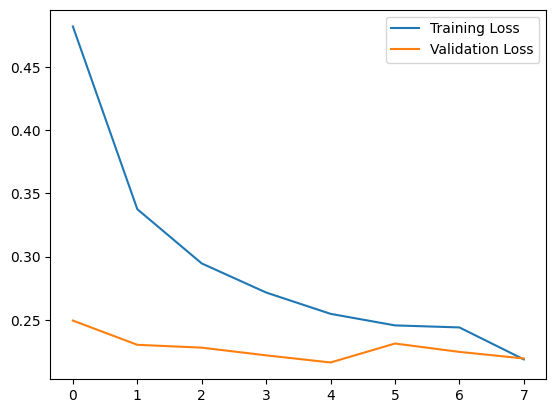

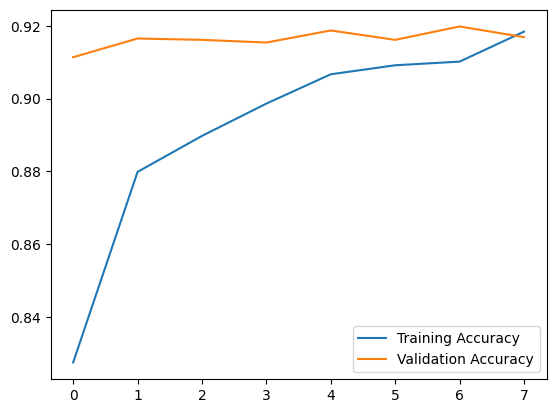

In [47]:
# ========= VISUALISASI =========
sns.lineplot(x=history.epoch, y=history.history['loss'], label='Training Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Validation Loss')
plt.show()

sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Training Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation Accuracy')
plt.show()

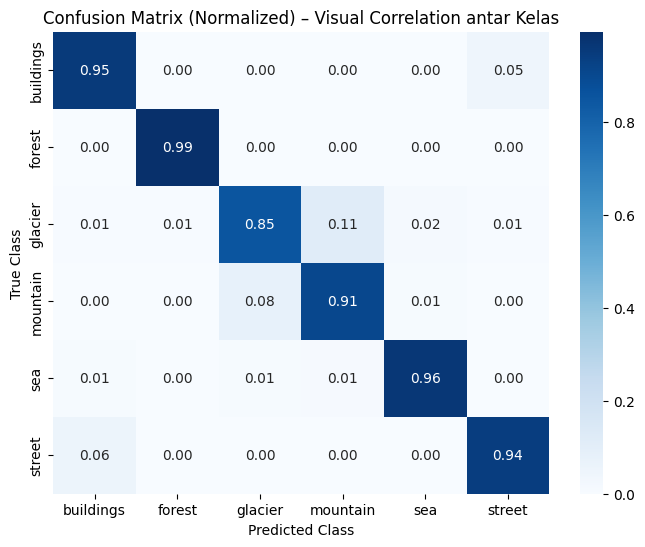

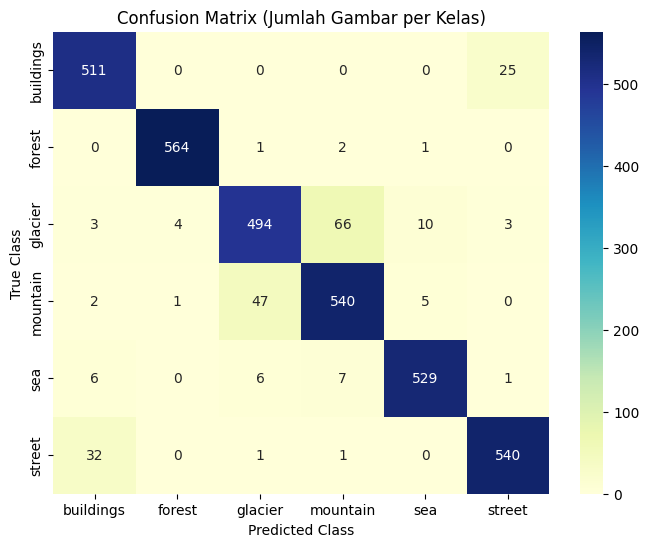

=== Jumlah Prediksi per Kelas ===
           buildings  forest  glacier  mountain  sea  street
buildings        511       0        0         0    0      25
forest             0     564        1         2    1       0
glacier            3       4      494        66   10       3
mountain           2       1       47       540    5       0
sea                6       0        6         7  529       1
street            32       0        1         1    0     540


In [48]:

from sklearn.metrics import confusion_matrix

# ======== Confusion Matrix ========
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisasi per baris

# ======== Visualisasi Heatmap ========
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=dataset.class_names,
            yticklabels=dataset.class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (Normalized) – Visual Correlation antar Kelas")
plt.show()


cm_count = confusion_matrix(y_true, y_pred)  # tanpa normalisasi
class_names = dataset.class_names  # pastikan sama dengan urutan kelas model kamu

# ========= TAMPILKAN HEATMAP JUMLAH GAMBAR =========
plt.figure(figsize=(8,6))
sns.heatmap(cm_count,
            annot=True,
            fmt="d",          # "d" artinya integer, bukan desimal
            cmap="YlGnBu",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (Jumlah Gambar per Kelas)")
plt.show()

# ========= BUAT DATAFRAME UNTUK ANALISIS DETAIL =========
df_cm = pd.DataFrame(cm_count, 
                     index=class_names, 
                     columns=class_names)

print("=== Jumlah Prediksi per Kelas ===")
print(df_cm)


Kelas terdeteksi: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


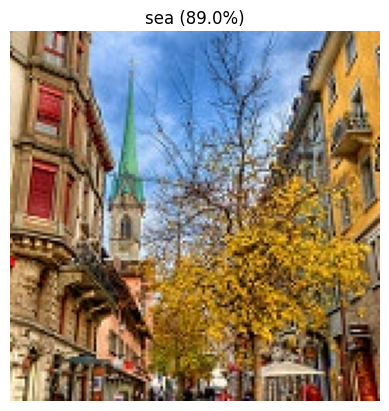

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


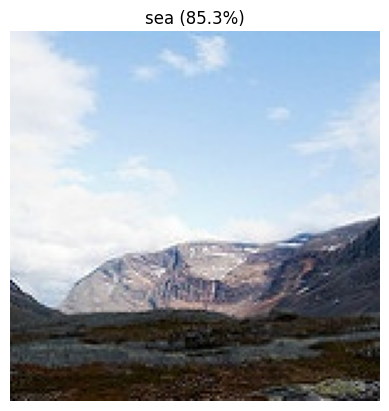

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

In [ ]:


# ========= PREDIKSI FOLDER GAMBAR BARU =========
import os


pred_dir = "seg_pred/seg_pred"

# Ambil semua path gambar (format umum: jpg/png/jpeg)
image_paths = [
    os.path.join(pred_dir, fname)
    for fname in os.listdir(pred_dir)
    if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Fungsi untuk load & preprocessing gambar
def load_and_prep_image(img_path, img_size=200):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0  # Normalisasi 0–1
    return img_array

# Ambil nama-nama kelas dari dataset training sebelumnya
class_names = dataset.class_names
print("Kelas terdeteksi:", class_names)

# ========= PROSES PREDIKSI =========
results = []  # list untuk menyimpan hasil prediksi

for img_path in image_paths:
    img = load_and_prep_image(img_path, img_size=200)
    preds = model.predict(img)
    
    pred_idx = np.argmax(preds)
    pred_class = class_names[pred_idx]
    confidence = np.max(preds) * 100
    
    results.append({
        "Nama File": os.path.basename(img_path),
        "Prediksi Kelas": pred_class,
        "Confidence (%)": round(confidence, 2)
    })

    # (Opsional) tampilkan contoh 1-2 gambar pertama
    if len(results) <= 2:
        plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
        plt.title(f"{pred_class} ({confidence:.1f}%)")
        plt.axis("off")
        plt.show()

# ========= EKSPOR KE CSV =========
df_results = pd.DataFrame(results)
output_path = "hasil_prediksi_resnet50.csv"
df_results.to_csv(output_path, index=False)

print(f"\n✅ Prediksi selesai! Total {len(results)} gambar diproses.")
print(f"Hasil disimpan ke: {output_path}")
df_results.head()


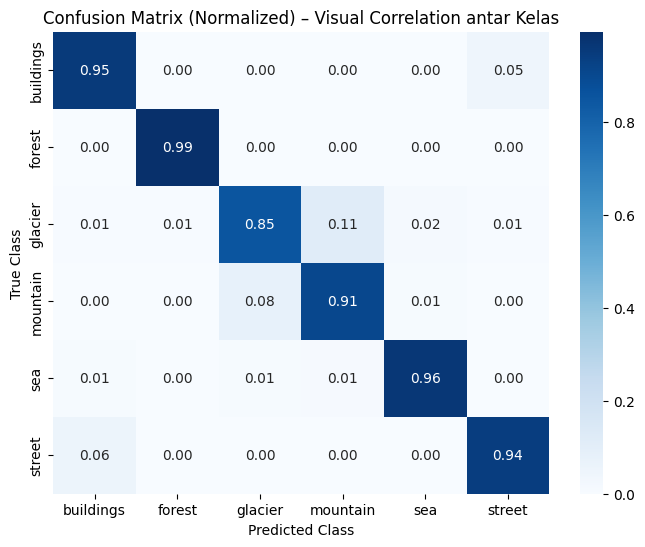

In [ ]:
# ======== Confusion Matrix ========
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisasi per baris

# ======== Visualisasi Heatmap ========
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=dataset.class_names,
            yticklabels=dataset.class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (Normalized) – Visual Correlation antar Kelas")
plt.show()